# 성능개선 기법 실습

# 모듈 정의

## train.py
- 모델 학습과 검증 함수 정의

In [1]:
import os
os.makedirs('module', exist_ok=True)

In [125]:
%%writefile module/train.py

import torch
import time

# multi와 binary 정확도 계산이 다르다.

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset) # 전체 데이터수
    num_batches = len(dataloader)  #  step 수
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 정확도 계산
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_batches
        test_accuracy /= size  #전체 개수로 나눈다.
    return test_loss, test_accuracy

def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_batches
        test_accuracy /= size   #전체 개수로 나눈다.
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    [parameter]
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi
    [return]
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy



def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, 
        save_best_model=True, save_model_path=None, 
        early_stopping=True, patience=10, 
        device='cpu',  mode:"binary or multi"='binary',
        lr_schedule=None
       ):
    """
    모델을 학습시키는 함수

    [parameter]
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (_Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
        lr_schedule: Learning Scheduler 객체. 한 epoch이 끝날 때 학습률 조정.(None이 아닐때)
    [return]
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
    """

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
        
    if save_best_model:
        best_score_save = torch.inf

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf
    
    # 모델 device로 옮기기
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        ### 학습
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, 
                                           device=device, mode=mode)
        
        # 학습률 조정
        if lr_schedule:
            lr_schedule.step()
            
        ### 검증
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 모델 저장
        if save_best_model:
            if val_loss < best_score_save: # 성능개선
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es: # 성능개선
                best_score_es = val_loss  
                trigger_count = 0
                                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Overwriting module/train.py


## data.py
- dataset 생성 함수 제공 모듈

In [3]:
%%writefile module/data.py
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(root_path, batch_size, is_train=True):
    """
    mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader 
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.MNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

def load_fashion_mnist_dataset(root_path, batch_size, is_train=True):
    """
    fashion mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

Overwriting module/data.py


In [4]:
# %%writefile module/utils.py
# import matplotlib.pyplot as plt 

def plot_fit_result(train_loss_list, train_acc_list, val_loss_list, val_acc_list):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(train_loss_list, label="Train")
    plt.plot(val_loss_list, label="Validation")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(train_acc_list, label="Train")
    plt.plot(val_acc_list, label="Validation")
    plt.legend()

    plt.tight_layout()
    plt.show()

## 하이퍼파라미터, 변수 정의

In [5]:
# import 

import torch
import torch.nn as nn
from torchinfo import summary

from module.train import fit
from module import data

import os
import matplotlib.pyplot as plt

In [6]:
# 데이터 저장할 디렉토리 경로
DATASET_ROOT_PATH = 'datasets'
MODEL_SAVE_ROOT_PATH = 'models'

N_EPOCH = 10
BATCH_SIZE = 256
LR = 0.001

# Data 준비

## mnist 데이터 로딩

In [7]:
train_loader = data.load_mnist_dataset(DATASET_ROOT_PATH, BATCH_SIZE, True)
test_loader = data.load_mnist_dataset(DATASET_ROOT_PATH, BATCH_SIZE, False)

In [8]:
print(train_loader)
print("step수:", len(train_loader))
print("dataset의 shape:", train_loader.dataset.data.shape)
print(train_loader.dataset)

step수: 235
dataset의 shape: torch.Size([60000, 28, 28])
Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


# 모델의 크기 변경에 따른 성능변화

In [9]:
class SizeCheckModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        # input -> output
        self.output = nn.Linear(28*28, 10)  # in: mnist 이미지크기(28*28), out: class개수(0~9: 10)
        
    def forward(self, X):
        out = nn.Flatten()(X)
        out = self.output(out)
        
        return out
        

In [10]:
model = SizeCheckModel()
summary(model, (256, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SizeCheckModel                           [256, 10]                 --
├─Linear: 1-1                            [256, 10]                 7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 2.01
Input size (MB): 0.80
Forward/backward pass size (MB): 0.02
Params size (MB): 0.03
Estimated Total Size (MB): 0.85

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device='cpu'  ## 그냥 cpu로 해도 된다.

In [12]:
# 학습
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

train_loss_list, train_acc_list, val_loss_list, val_acc_list = \
   fit(train_loader, test_loader, model, loss_fn, optimizer, N_EPOCH, 
       save_best_model=False, early_stopping=False, device=device, mode="multi")

Epoch[1/10] - Train loss: 0.48615 Train Accucracy: 0.88033 || Validation Loss: 0.46225 Validation Accuracy: 0.88870
Epoch[2/10] - Train loss: 0.38025 Train Accucracy: 0.89982 || Validation Loss: 0.36107 Validation Accuracy: 0.90640
Epoch[3/10] - Train loss: 0.33893 Train Accucracy: 0.90893 || Validation Loss: 0.32273 Validation Accuracy: 0.91240
Epoch[4/10] - Train loss: 0.31660 Train Accucracy: 0.91370 || Validation Loss: 0.30283 Validation Accuracy: 0.91690
Epoch[5/10] - Train loss: 0.30269 Train Accucracy: 0.91737 || Validation Loss: 0.29317 Validation Accuracy: 0.91730
Epoch[6/10] - Train loss: 0.29239 Train Accucracy: 0.91935 || Validation Loss: 0.28402 Validation Accuracy: 0.92010
Epoch[7/10] - Train loss: 0.28480 Train Accucracy: 0.92155 || Validation Loss: 0.27798 Validation Accuracy: 0.92160
Epoch[8/10] - Train loss: 0.27904 Train Accucracy: 0.92270 || Validation Loss: 0.27511 Validation Accuracy: 0.92330
Epoch[9/10] - Train loss: 0.27492 Train Accucracy: 0.92365 || Validation

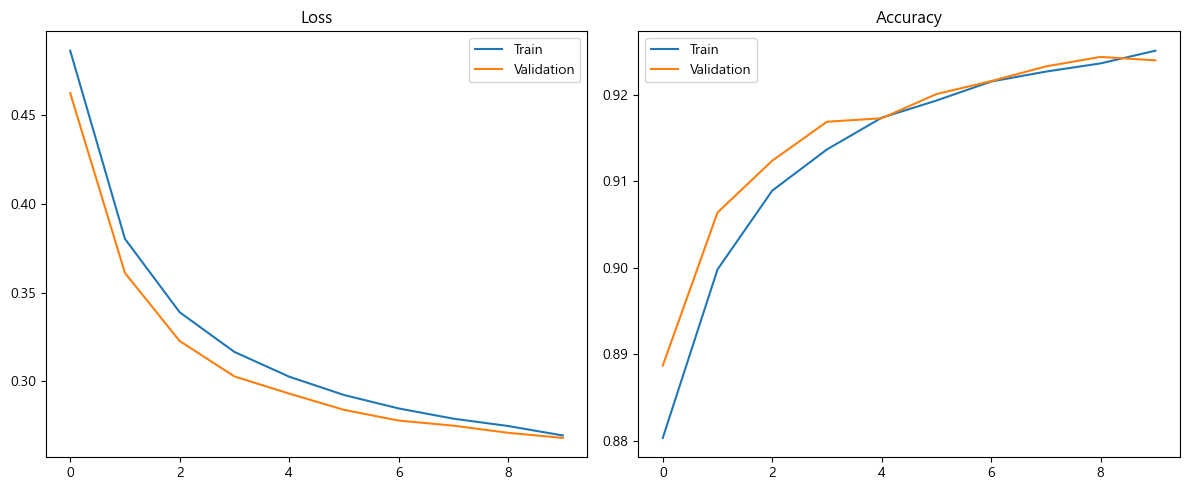

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(train_loss_list, label="Train")
plt.plot(val_loss_list, label="Validation")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(train_acc_list, label="Train")
plt.plot(val_acc_list, label="Validation")
plt.legend()

plt.tight_layout()
plt.show()

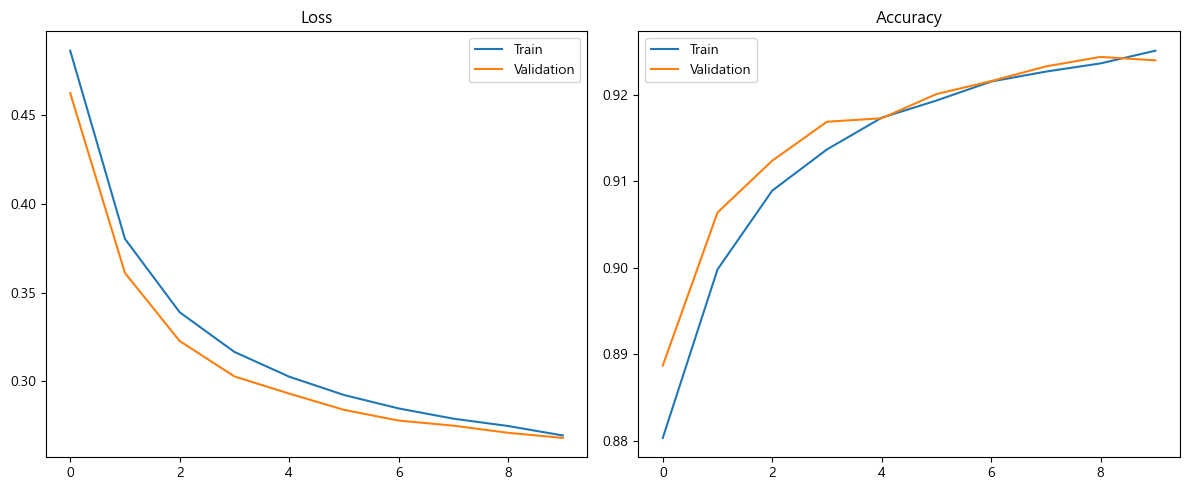

In [14]:
# from module.utils import plot_fit_result
plot_fit_result(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

In [15]:
# nn.ReLU()(nn.Linear()(X))

TypeError: Linear.__init__() missing 2 required positional arguments: 'in_features' and 'out_features'

In [16]:
# Layer block 정의, 단순 순차구조의 모델을 정의.
# 가변인자 형식으로 넣어준다.
# Layer block 정의,
b1 = nn.Sequential(
        nn.Linear(64, 32), 
        nn.ReLU()
     )

o = b1(X)
# Sequential 이 아래처럼 순차적으로 처리해서 결과를 반환.
# t = nn.Linear(64, 32)(X) 
# o = nn.ReLU()(t)

NameError: name 'X' is not defined

In [17]:
class SizeCheckModel_2(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(28*28, 2048), 
                                    nn.ReLU())
        self.block2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.block3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.block4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.block5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.block6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        
        self.output = nn.Linear(64, 10)
        
    def forward(self, X):    # 입력 (batch, 1,  28, 28)
        out = nn.Flatten()(X)    # (batch, 1*28*28)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.output(out)
        
        return out
        

In [18]:
big_model = SizeCheckModel_2().to(device)
summary(big_model, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SizeCheckModel_2                         [256, 10]                 --
├─Sequential: 1-1                        [256, 2048]               --
│    └─Linear: 2-1                       [256, 2048]               1,607,680
│    └─ReLU: 2-2                         [256, 2048]               --
├─Sequential: 1-2                        [256, 1024]               --
│    └─Linear: 2-3                       [256, 1024]               2,098,176
│    └─ReLU: 2-4                         [256, 1024]               --
├─Sequential: 1-3                        [256, 512]                --
│    └─Linear: 2-5                       [256, 512]                524,800
│    └─ReLU: 2-6                         [256, 512]                --
├─Sequential: 1-4                        [256, 256]                --
│    └─Linear: 2-7                       [256, 256]                131,328
│    └─ReLU: 2-8                         [256, 256]          

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=LR)

result = fit(train_loader, test_loader, big_model, loss_fn, optimizer, N_EPOCH, 
             save_best_model=False, early_stopping=False, 
             device=device, mode='multi')

Epoch[1/10] - Train loss: 0.11516 Train Accucracy: 0.96762 || Validation Loss: 0.12186 Validation Accuracy: 0.96290
Epoch[2/10] - Train loss: 0.09287 Train Accucracy: 0.97140 || Validation Loss: 0.12512 Validation Accuracy: 0.96200
Epoch[3/10] - Train loss: 0.04480 Train Accucracy: 0.98710 || Validation Loss: 0.07769 Validation Accuracy: 0.97520
Epoch[4/10] - Train loss: 0.03766 Train Accucracy: 0.98808 || Validation Loss: 0.08475 Validation Accuracy: 0.97630
Epoch[5/10] - Train loss: 0.04139 Train Accucracy: 0.98698 || Validation Loss: 0.09500 Validation Accuracy: 0.97460
Epoch[6/10] - Train loss: 0.03039 Train Accucracy: 0.99088 || Validation Loss: 0.07429 Validation Accuracy: 0.97960
Epoch[7/10] - Train loss: 0.02030 Train Accucracy: 0.99333 || Validation Loss: 0.08031 Validation Accuracy: 0.97810
Epoch[8/10] - Train loss: 0.02222 Train Accucracy: 0.99342 || Validation Loss: 0.08193 Validation Accuracy: 0.97760
Epoch[9/10] - Train loss: 0.01188 Train Accucracy: 0.99630 || Validation

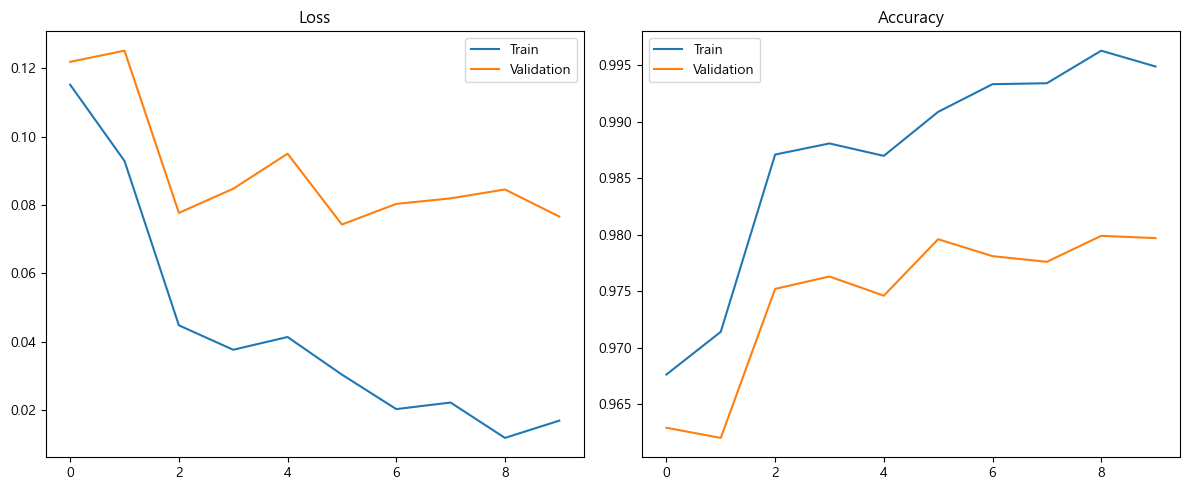

In [20]:
plot_fit_result(*result)

# Dropout 예제
- dropout 각 레이어에 적용
    - dropout은 nn.Dropout 객체를 사용
    - 객체 생성시 dropout_rate 설정: 0.2 ~ 0.5
    - Drop시킬 노드를 가진 Layer 뒤에 추가한다.

In [21]:
x = torch.randn(5, 3)
print(x.shape)
x

torch.Size([5, 3])


tensor([[ 0.5621, -1.6447, -0.5302],
        [-0.0993,  0.4250, -0.1064],
        [ 1.5807, -0.5039, -0.1954],
        [-0.1309, -0.6929, -1.0259],
        [-0.0420, -0.1508, -0.2194]])

In [22]:
ln_layer = nn.Linear(3, 4)
y = ln_layer(x)

In [23]:
y

tensor([[ 0.8488,  1.1699,  0.4469,  1.1178],
        [-0.0571,  0.2316, -0.1477, -0.4633],
        [ 1.0120,  0.3737, -0.0812,  0.7680],
        [ 0.4336,  1.1067,  0.5207,  0.4945],
        [ 0.1302,  0.5120,  0.0298, -0.0766]], grad_fn=<AddmmBackward0>)

In [24]:
do_layer = nn.Dropout(0.2)  # 0.5 dropout rate
z = do_layer(y)

In [25]:
z

tensor([[ 1.0610,  1.4624,  0.5586,  1.3972],
        [-0.0713,  0.2895, -0.1846, -0.5791],
        [ 1.2650,  0.4671, -0.1015,  0.9600],
        [ 0.5420,  1.3834,  0.0000,  0.0000],
        [ 0.1628,  0.6400,  0.0000, -0.0957]], grad_fn=<MulBackward0>)

### MNIST 적용

In [26]:
class DropoutModel(nn.Module):  
    
#     nn.Dropout(p=0.3)(nn.ReLU()(nn.Linear()(out)))
    
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(28*28, 2048), 
                                    nn.Dropout(p=0.5),   # default: 0.5 -> 50% node를 dropout
                                    nn.ReLU())
        self.block2 = nn.Sequential(nn.Linear(2048, 1024), nn.Dropout(p=0.5), nn.ReLU())
        self.block3 = nn.Sequential(nn.Linear(1024, 512), nn.Dropout(p=0.5), nn.ReLU())
        self.block4 = nn.Sequential(nn.Linear(512, 256), nn.Dropout(p=0.5), nn.ReLU())
        self.block5 = nn.Sequential(nn.Linear(256, 128), nn.Dropout(p=0.5), nn.ReLU())
        self.block6 = nn.Sequential(nn.Linear(128, 64), nn.Dropout(p=0.5), nn.ReLU())
        
        self.output = nn.Linear(64, 10)
        
    def forward(self, X):    # 입력 (batch, 1,  28, 28)
        out = nn.Flatten()(X)    # (batch, 1*28*28)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.output(out)
        out = nn.Dropout(p=0.5)(out)  # 마지막 출력 layer에 dropout 적용.
        
        return out
        

In [27]:
d_model = DropoutModel().to(device)
summary(d_model, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DropoutModel                             [256, 10]                 --
├─Sequential: 1-1                        [256, 2048]               --
│    └─Linear: 2-1                       [256, 2048]               1,607,680
│    └─Dropout: 2-2                      [256, 2048]               --
│    └─ReLU: 2-3                         [256, 2048]               --
├─Sequential: 1-2                        [256, 1024]               --
│    └─Linear: 2-4                       [256, 1024]               2,098,176
│    └─Dropout: 2-5                      [256, 1024]               --
│    └─ReLU: 2-6                         [256, 1024]               --
├─Sequential: 1-3                        [256, 512]                --
│    └─Linear: 2-7                       [256, 512]                524,800
│    └─Dropout: 2-8                      [256, 512]                --
│    └─ReLU: 2-9                         [256, 512]               

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(d_model.parameters(), lr=LR)

result = fit(train_loader, test_loader, d_model, loss_fn, optimizer, N_EPOCH, 
             save_best_model=False, early_stopping=False, 
             device=device, mode='multi')

Epoch[1/10] - Train loss: 1.20393 Train Accucracy: 0.54443 || Validation Loss: 1.19600 Validation Accuracy: 0.54240
Epoch[2/10] - Train loss: 0.98529 Train Accucracy: 0.57907 || Validation Loss: 0.99271 Validation Accuracy: 0.57030
Epoch[3/10] - Train loss: 0.95334 Train Accucracy: 0.58355 || Validation Loss: 0.96739 Validation Accuracy: 0.57700
Epoch[4/10] - Train loss: 0.94304 Train Accucracy: 0.58575 || Validation Loss: 0.94275 Validation Accuracy: 0.58750
Epoch[5/10] - Train loss: 0.91297 Train Accucracy: 0.59003 || Validation Loss: 0.93727 Validation Accuracy: 0.59310
Epoch[6/10] - Train loss: 0.91099 Train Accucracy: 0.58898 || Validation Loss: 0.93557 Validation Accuracy: 0.58420
Epoch[7/10] - Train loss: 0.91360 Train Accucracy: 0.58983 || Validation Loss: 0.93180 Validation Accuracy: 0.58590
Epoch[8/10] - Train loss: 0.89716 Train Accucracy: 0.58917 || Validation Loss: 0.91680 Validation Accuracy: 0.58680
Epoch[9/10] - Train loss: 0.89585 Train Accucracy: 0.59135 || Validation

# Batch Normalization
- Dense => BN => Activation

In [29]:
torch.manual_seed(0)
input_data = torch.rand(10, 5)
bn = nn.BatchNorm1d(5)   #BatchNorm1d(feature수) -> X가 1차원, BatchNorm2d() -> X가 2차원(이미지)
output_data = bn(input_data)

In [30]:
print(input_data.mean(dim=0))
print(input_data.std(dim=0))

tensor([0.4338, 0.6425, 0.4724, 0.3281, 0.3822])
tensor([0.1993, 0.2852, 0.3720, 0.2740, 0.1943])


In [31]:
print(output_data.mean(dim=0))
print(output_data.std(dim=0))
# 평균, 표준편차가 feature별로 통일->scaling

tensor([-1.7881e-07, -7.1526e-08,  1.1921e-07,  3.5763e-08,  5.9605e-08],
       grad_fn=<MeanBackward1>)
tensor([1.0539, 1.0540, 1.0541, 1.0540, 1.0539], grad_fn=<StdBackward0>)


### MNIST

In [32]:
# Linear() -> BNorm() -> ReLU() (->Dropout)

class BNModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(28*28, 256), 
                                    nn.BatchNorm1d(256), # 앞 Layer의 out_features에 맞춰준다.
                                    nn.ReLU())
        self.block2 = nn.Sequential(nn.Linear(256, 128), 
                                    nn.BatchNorm1d(128), 
                                    nn.ReLU())
        
        self.block3 = nn.Sequential(nn.Linear(128, 64), 
                                    nn.BatchNorm1d(64),
                                    nn.ReLU())
        self.output = nn.Linear(64, 10)
        
    def forward(self, X):
        out = nn.Flatten()(X)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.output(out)
        return out

In [33]:
bn_model = BNModel().to(device)
optimizer = torch.optim.Adam(bn_model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

summary(bn_model, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BNModel                                  [256, 10]                 --
├─Sequential: 1-1                        [256, 256]                --
│    └─Linear: 2-1                       [256, 256]                200,960
│    └─BatchNorm1d: 2-2                  [256, 256]                512
│    └─ReLU: 2-3                         [256, 256]                --
├─Sequential: 1-2                        [256, 128]                --
│    └─Linear: 2-4                       [256, 128]                32,896
│    └─BatchNorm1d: 2-5                  [256, 128]                256
│    └─ReLU: 2-6                         [256, 128]                --
├─Sequential: 1-3                        [256, 64]                 --
│    └─Linear: 2-7                       [256, 64]                 8,256
│    └─BatchNorm1d: 2-8                  [256, 64]                 128
│    └─ReLU: 2-9                         [256, 64]                 --


In [34]:
result_bn = fit(train_loader, test_loader, bn_model, loss_fn, optimizer, N_EPOCH, 
             save_best_model=False, early_stopping=False, 
             device=device, mode='multi')

Epoch[1/10] - Train loss: 0.09558 Train Accucracy: 0.97593 || Validation Loss: 0.11030 Validation Accuracy: 0.96930
Epoch[2/10] - Train loss: 0.05086 Train Accucracy: 0.98682 || Validation Loss: 0.07811 Validation Accuracy: 0.97690
Epoch[3/10] - Train loss: 0.03192 Train Accucracy: 0.99200 || Validation Loss: 0.07049 Validation Accuracy: 0.97980
Epoch[4/10] - Train loss: 0.02397 Train Accucracy: 0.99347 || Validation Loss: 0.06841 Validation Accuracy: 0.97880
Epoch[5/10] - Train loss: 0.02190 Train Accucracy: 0.99385 || Validation Loss: 0.07380 Validation Accuracy: 0.97890
Epoch[6/10] - Train loss: 0.01208 Train Accucracy: 0.99702 || Validation Loss: 0.06646 Validation Accuracy: 0.97910
Epoch[7/10] - Train loss: 0.01208 Train Accucracy: 0.99648 || Validation Loss: 0.06611 Validation Accuracy: 0.98000
Epoch[8/10] - Train loss: 0.00756 Train Accucracy: 0.99822 || Validation Loss: 0.06171 Validation Accuracy: 0.98160
Epoch[9/10] - Train loss: 0.00911 Train Accucracy: 0.99752 || Validation

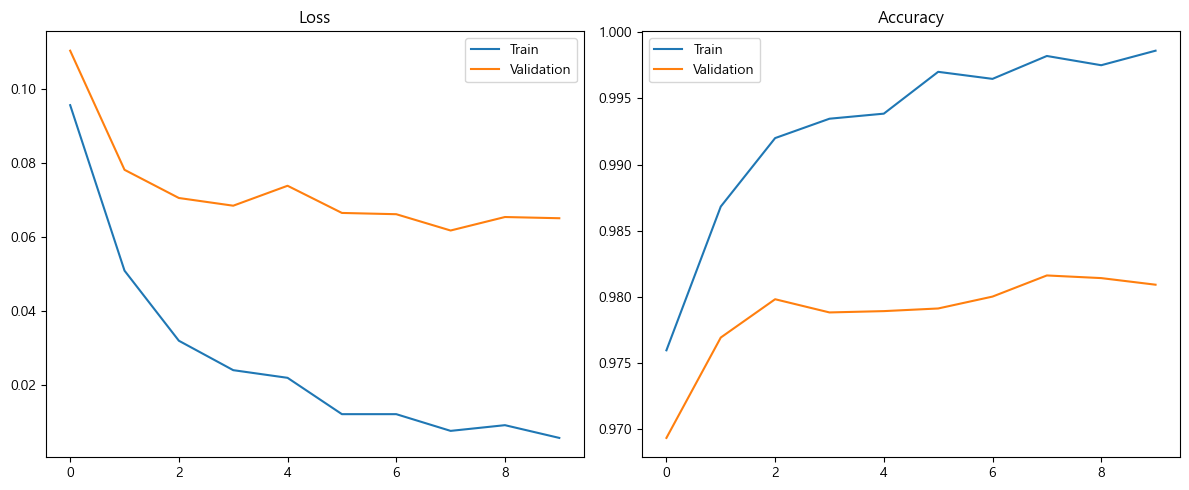

In [35]:
plot_fit_result(*result_bn)

# Learning rate decay

### Optimizer와 Learning rate scheduler의 속성, 메소드 확인
- 파이토치는 `torch.optim` 모듈에서 다양한 Learning rate 알고리즘을 제공한다.

In [36]:
optimizer=torch.optim.Adam(bn_model.parameters(),lr=0.001) # 초기 parameter(학습률) 0.001

## optimzer 관련 정보 조회
type(optimizer.param_groups[0])
info_dict=optimizer.param_groups[0]
info_dict.keys()

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'maximize', 'foreach', 'capturable', 'differentiable', 'fused'])

In [37]:
info_dict['lr'] ## 넣어준 optimizer의 학습률 값이 나오고 여기서 값을 변경할 수도 있다.

0.001

In [38]:
optimizer=torch.optim.Adam(bn_model.parameters(), lr=0.001)

# scheduler가 optimizer의 LR를 학습도중 변경한다.(param_groups[0]['lr']의 값을 변경)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=0.5)

In [39]:
# 현재 optimizer의 learning rate
optimizer.param_groups[0]['lr'], scheduler.get_last_lr()

(0.001, [0.001])

In [110]:
##### 학습률이 변화 흐름을 선그래프로 그리는 함수
def plot_lr(name, lr_list):
    # name : scheduler name
    # lr_list : list contain the each epoch's learning rate 
    plt.figure(figsize=(10,5))
    plt.plot(range(len(lr_list)),lr_list)
    
    plt.title(f'Scheduler:{name}')
    x_tick=[x for x in range(len(lr_list)) if x % 5 ==0]
    plt.xticks(x_tick, rotation=45)
    plt.xlabel('Epoch')
    plt.ylabel('learning rate')
    plt.grid(True, axis='x',linestyle=':')
    plt.show()

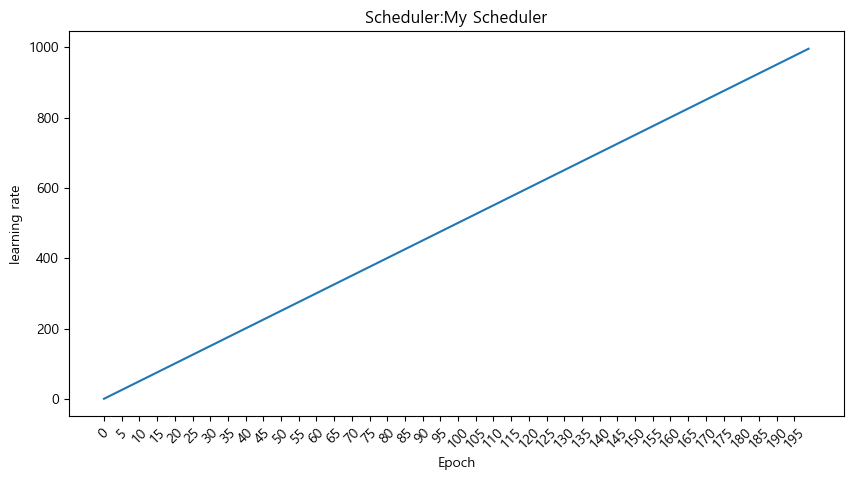

In [107]:
plot_lr('My Scheduler', list(range(1,1000,5)))

In [108]:
##### 학습률이 변화 흐름을 선그래프로 그리는 함수
def plot_lr_2(name, lr_list):
    # name : scheduler name
    # lr_list : list contain the each epoch's learning rate 
    plt.figure(figsize=(10,5))
    plt.plot(range(len(lr_list)),lr_list)
    
    plt.title(f'Scheduler:{name}')
    x_tick=[x for x in range(len(lr_list)) if x % 5 ==0]   ## 이 list가 눈금 grid 생기는 부분 정한다.
    plt.xticks(x_tick, rotation=45)                          
    plt.xlabel('Epoch')
    plt.ylabel('learning rate')
    plt.grid(True, axis='x',linestyle=':')
    plt.show()
    

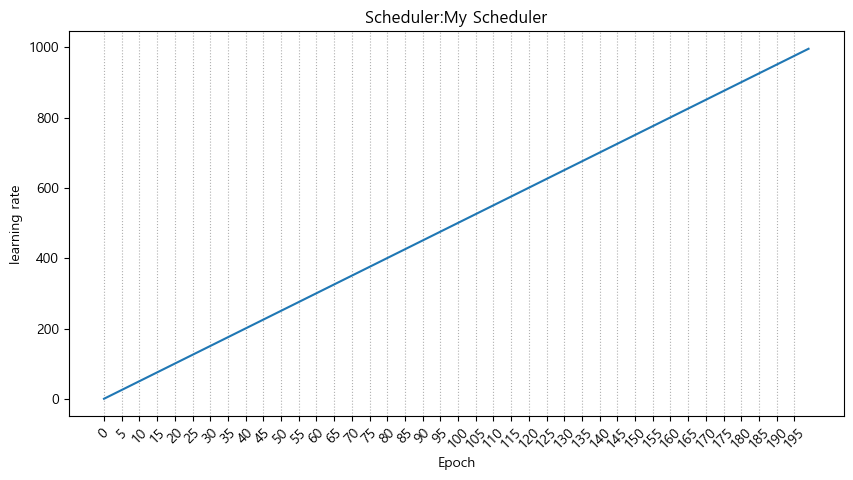

In [109]:
plot_lr_2('My Scheduler', list(range(1,1000,5)))

#### StepLR

In [79]:
optimizer=torch.optim.Adam(bn_model.parameters(), lr=0.001) # lr => 초기 학습률
step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, # learning rate를 변화시킬 optimizer
                                                 step_size=5, # 몇 epoch마다 lr을 변경시킬 것인지
                                                 gamma=0.5 # 학습률을 변화시킬 비율
                                                 
                                                )


In [80]:
step_size=5
gamma=0.5
lr = 0.001
f" optimizer의 학습률을 {step_size} epoch마다 {gamma}배씩 변화시킨다. {lr * gamma} => 새 학습률"

' optimizer의 학습률을 5 epoch마다 0.5배씩 변화시킨다. 0.0005 => 새 학습률'

In [81]:
N_EPOCH=100
STEP_SIZE=10
lr_list=[]
for i in range(N_EPOCH):
    # 학습 - 배치단위 진행
    for _ in range(STEP_SIZE):
        # 추정 -> LOSS 계산 -> 역전파(기울기 계산)
        optimizer.step()
    
    step_scheduler.step() # 한 epoch 학습이 끝나면 learning rate 업데이트 처리
    lr_list.append(step_scheduler.get_last_lr()) # scheduler.step() 후 learning rate를 저장
    
    

In [112]:
# 계단 형식으로 떨어트리는 형식
optimizer = torch.optim.Adam(bn_model.parameters(),lr=0.001) # Lr = 초기 학습률
step_scheduler= torch.optim.lr_scheduler.StepLR(optimizer, # 학습률을 변화시킬 optimizer
                                               step_size=25, # 몇 에폭 마다 lr을 변경시킬 것인지
                                               gamma = 0.5 # 학습률을 변화시킬 비율
                                               )
step_size, gamma,lr = 5, 0.5 ,0.001
f"optimizer의 합습률을 {step_size} 에폭마다 {gamma}배씩 변화시킨다. {lr*gamma}==> 새학습률"
N_EPOCH=100
STEP_SIZE=10
lr_list= []
for i in range(N_EPOCH):
    # 학습 - 배치
    for _ in range(STEP_SIZE):
        # 추정 -> Loss 계산 -> 역젆파(기울기 계산)
        optimizer.step() # 파라미터가 업데이트 됨
    step_scheduler.step() #  한 에폭 학습이 끝나면 Learing rate 업데이트 처리.
    lr_list.append(step_scheduler.get_last_lr()[0]) # scheduler.step() 후 Learning rate를 저장



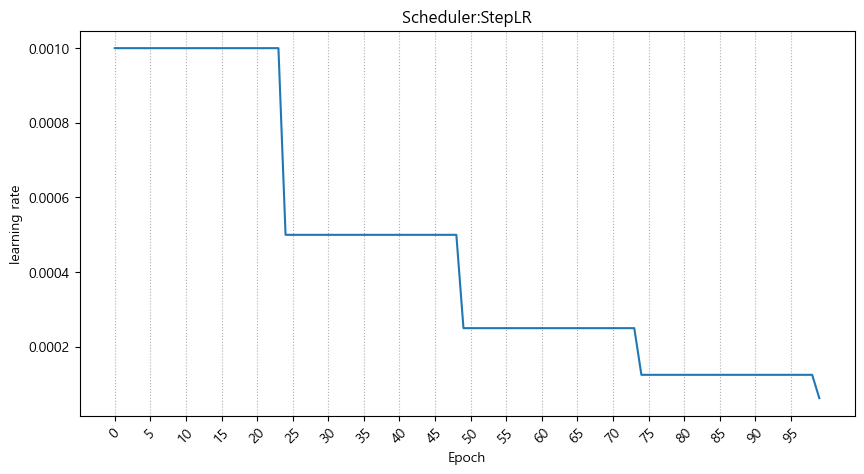

In [113]:
plot_lr('StepLR',lr_list)

In [114]:
# 계단 형식으로 떨어트리는 형식
optimizer = torch.optim.Adam(bn_model.parameters(),lr=0.001) # Lr = 초기 학습률
step_scheduler= torch.optim.lr_scheduler.StepLR(optimizer, # 학습률을 변화시킬 optimizer
                                               step_size=5, # 몇 에폭 마다 lr을 변경시킬 것인지
                                               gamma = 0.5 # 학습률을 변화시킬 비율
                                               )
step_size, gamma,lr = 5, 0.5 ,0.001
f"optimizer의 합습률을 {step_size} 에폭마다 {gamma}배씩 변화시킨다. {lr*gamma}==> 새학습률"
N_EPOCH=100
STEP_SIZE=10
lr_list= []
for i in range(N_EPOCH):
    # 학습 - 배치
    for _ in range(STEP_SIZE):
        # 추정 -> Loss 계산 -> 역젆파(기울기 계산)
        optimizer.step() # 파라미터가 업데이트 됨
    step_scheduler.step() #  한 에폭 학습이 끝나면 Learing rate 업데이트 처리.
    lr_list.append(step_scheduler.get_last_lr()[0]) # scheduler.step() 후 Learning rate를 저장


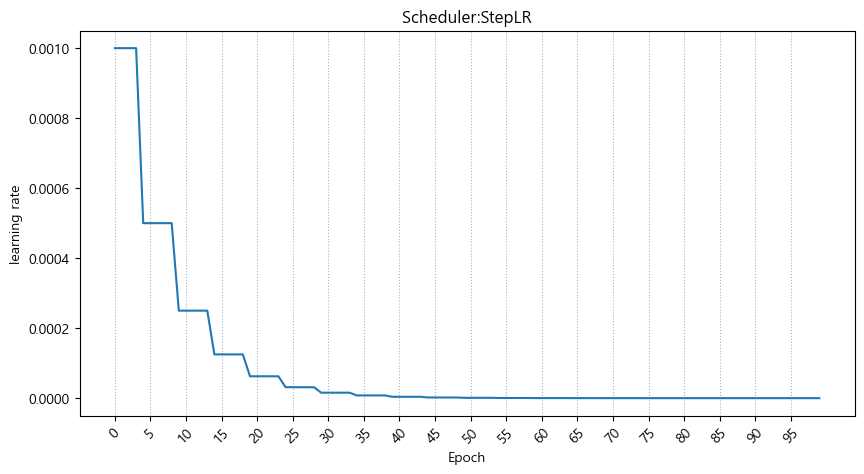

In [115]:
plot_lr('StepLR',lr_list)

#### CosineAnnealingLR
cosine 그래프를 그리면서 learning rate를 변경 하는 방식.  
최근에는 learning rate를 단순히 감소시키기 보다는 감소와 증가를 반복하여 진동하는 방식으로 최적점을 찾아가는 알고리즘을 많이 사용한다. 이러한 방법 중 가장 간단하면서도 많이 사용되는 방법이 CosineAnnealingLR이다.

In [100]:
optimizer.param_groups[0]['lr']

9.5367431640625e-10

In [101]:
# Annealing - 가열 - 냉각
optimizer = torch.optim.Adam(bn_model.parameters(),lr=0.001)
ca_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                          T_max=10, # 1 cycle period(단위:)
                                                          eta_min=0.00001 # 최소 학습률
                                                         )
lr_list2 = []
for _ in range(N_EPOCH):
    for _ in range(STEP_SIZE):
        optimizer.step()
    ca_scheduler.step()
    lr_list2.append(ca_scheduler.get_last_lr()[0])

In [102]:
lr_list2

[0.0009757729755661011,
 0.000905463412215599,
 0.0007959536998847742,
 0.000657963412215599,
 0.000505,
 0.0003520365877844011,
 0.00021404630011522585,
 0.00010453658778440107,
 3.4227024433899005e-05,
 1e-05,
 3.4227024433899005e-05,
 0.00010453658778440146,
 0.00021404630011522671,
 0.00035203658778440265,
 0.0005050000000000023,
 0.000657963412215602,
 0.0007959536998847778,
 0.0009054634122156032,
 0.0009757729755661056,
 0.0010000000000000046,
 0.0009757729755661055,
 0.0009054634122156035,
 0.0007959536998847779,
 0.0006579634122156021,
 0.0005050000000000024,
 0.0003520365877844028,
 0.00021404630011522688,
 0.00010453658778440157,
 3.4227024433899175e-05,
 1e-05,
 3.4227024433899005e-05,
 0.00010453658778440114,
 0.00021404630011522612,
 0.0003520365877844016,
 0.000505000000000001,
 0.0006579634122156004,
 0.0007959536998847761,
 0.0009054634122156011,
 0.0009757729755661035,
 0.0010000000000000026,
 0.000975772975566104,
 0.0009054634122156017,
 0.0007959536998847766,
 0.00

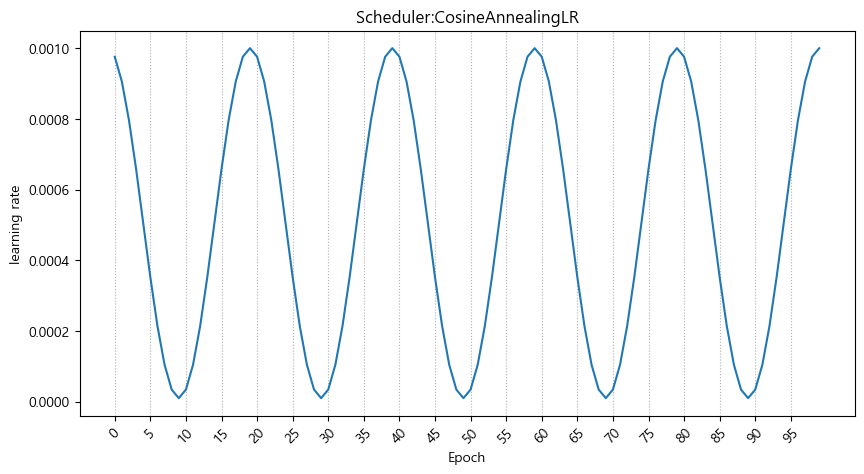

In [116]:
plot_lr('CosineAnnealingLR',lr_list2)

#### CosineAnnealingWarmRestarts

cosine annealing의 스케쥴링에 cosine 주기의 에폭을 점점 늘리거나 줄일 수 있다. (보통 늘린다.)

In [121]:
optimizer = torch.optim.Adam(bn_model.parameters(),lr=0.001)
caw_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # 초기 cycle 주기
    T_mult=2, # T_0 를 어떤 비율로 변경할지. T_0에 곱한 것이 새 주기가 된다.
    eta_min=1e-5 # 변환 시 최소 학습률
)

In [122]:
lr_list3=[]
for _ in range(N_EPOCH):
    for _ in range(STEP_SIZE):
        optimizer.step()
        
    caw_scheduler.step()
    lr_list3.append(caw_scheduler.get_last_lr()[0])

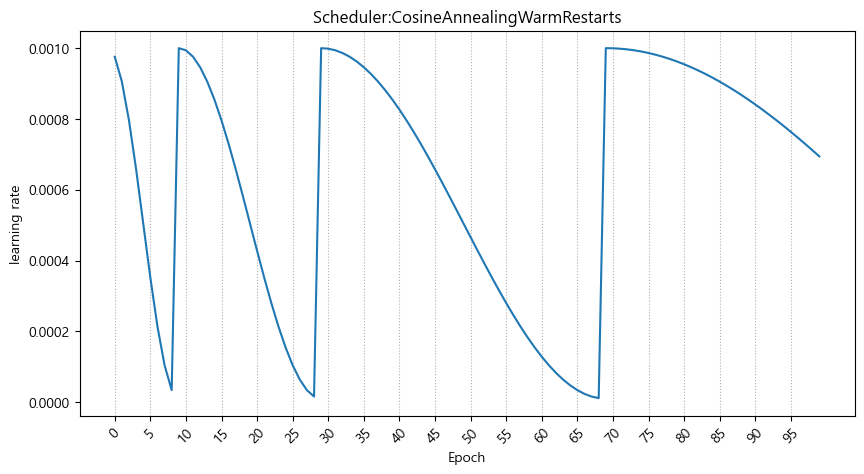

In [123]:
plot_lr('CosineAnnealingWarmRestarts',lr_list3)